# <center>Minimum Transformation Method
## <center>An inverse model for inferring surface fluxes and mixing from gridded hydrographic TS data, <br> by Taimoor Sohail and Jan D. Zika



##### <center>We use an optimal transport method, minimzing a cost function which respects the volume and mass conservation, and the fundamental physics of mixing in TS space. <br>See also: Jan D Zika et al. (2021) [www.doi.org/10.1175/JCLI-D-20-0355.1 ] for a simpler version of this model which optimizes ocean circulation only.
------------

### __The code is laid out as follows:__
#### A) Pre-processing
i) Load necessary modules for computation \
ii) Define key parameters
#### B) Load Data
#### C) Define constraints
i) Define Connectivity \
ii) Define weights
#### D) Run optimisation
#### E) Save Output
---------

## A) Pre-processing

### i) Load necessary modules for computation

In [1]:
## Module to run the minimisation
from WM_Methods import MTM
## Module to track runtime of cells and loops
import time
from tqdm.notebook import tqdm
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
## Module to load files and handle array computations
import xarray as xr
import numpy as np
## Modules to plot outputs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
# Specify font properties for plots
# from matplotlib import rc
# font = {'family' : 'DejaVu Sans',
#         'weight' : 'normal',
#         'size'   : 16}

# rc('font', **font)

### ii) Define key parameters

In [2]:
# If Surface fluxes are available
SF = True

In [3]:
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients
ST_scale=bet/alph

# Establish basic constants 
yr2sec = 365.25*24*60*60
Cp=4000
rho=1024
S0=35

# To run the optimisation twice 
Opt_twice = False

# Range of years of which 'early' and 'late' are defined

dyrs = 9
init_early = 1979
init_late = 2006
Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12
Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12
range_yrs = init_late-init_early+1

-----------
## B) Load Data



The data is presented as monthly T-S observations from EN4, from January 1970 to December 2014. The observations have already been binned via Binary Space Partitioning according to a specific criterion. Folowing Sohail et al. (TBD) the BSP partitioning occurs in an xyxyxyx order, shown to minimize variability in the temperature and salinity signals. 



In [4]:
%%time
ERA5_BSP_data = xr.open_mfdataset('BSP_processed/BSP_ERA5_TS_*.nc')

## Early Period
Part_early = ERA5_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ERA5_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ERA5_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
V_early = ERA5_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ERA5_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
Asection_early = ERA5_BSP_data.Asection_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ERA5_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ERA5_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ERA5_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
V_late = ERA5_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ERA5_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
Asection_late = ERA5_BSP_data.Asection_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ERA5_BSP_data.Basin.values
Sections = ERA5_BSP_data.Section.values


CPU times: user 404 ms, sys: 57.7 ms, total: 462 ms
Wall time: 586 ms


In [5]:
ERA5_BSP_data.hfds_sum

<xarray.DataArray 'hfds_sum' (Basin: 9, Time: 408, Depth: 128)>
dask.array<concatenate, shape=(9, 408, 128), dtype=float64, chunksize=(9, 24, 128), chunktype=numpy.ndarray>
Coordinates:
  * Basin    (Basin) object 'Polar N. Atlantic' ... 'Southern Ocean'
  * Time     (Time) float64 0.0 1.0 2.0 3.0 4.0 ... 404.0 405.0 406.0 407.0
  * Depth    (Depth) int64 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
Attributes:
    description:  Net surface heat flux (ERA5)
    units:        J
    variable_id:  Basin V_sum

In [6]:
## Load ERA5 data here, if provided
if SF:
    ## Calculate the cumulative time integrated surface fluxes 
    HFDS_cumsum = ERA5_BSP_data.hfds_sum.cumsum('Time').isel(Time=-1)*(1/(24*3600))*(yr2sec/12) # units: J
    WFO_cumsum = ERA5_BSP_data.wfo_sum.cumsum('Time').isel(Time=-1)*yr2sec/12 # units: kg

    ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs))
    dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs))

    ## Convert dflux to equivalent T or S change

    dT_hfds = dhfds/(Cp*rho*V_early) # Is Vlate the right choice here? # units: C
    dS_wfo = -dwfo*S0/(rho*V_early) # Is Vlate the right choice here? # units: g/kg

    time = ERA5_BSP_data.Time.values

In [7]:
## Check for heat and salt closure
## HEAT
(ACCESS_BSP_data.hfds_sum*dt.average_DT).cumsum('Time').sum('Basin').sum('Depth').plot(label='Time-integrated surface heat flux')
((rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).sum('Basin').sum('Depth'))-(rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).sum('Basin').sum('Depth').isel(Time=0))).plot(label='Temperature-derived mass change')
plt.title('OHC change (J)')
plt.legend()
plt.show()
## SALT
((ACCESS_BSP_data.wfo_sum*dt.average_DT).cumsum('Time')-((ACCESS_BSP_data.wfo_sum*dt.average_DT).cumsum('Time').isel(Time=slice(0,120)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Time-integrated surface FW flux')
((-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum)-(-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum).isel(Time=slice(0,120)).mean('Time')).sum('Basin').sum('Depth').plot(label='Salinity-derived mass change')
plt.title('Mass Change (kg)')
plt.legend()
plt.show()

array([[-1.32983728e+23, -1.80497335e+22, -1.65380967e+22, ...,
        -7.48110140e+20, -1.64591518e+22,  9.12082443e+21],
       [-1.96754878e+18, -1.87703591e+19,  0.00000000e+00, ...,
         7.23820475e+21, -8.37085797e+22,  1.04472646e+23],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.67183375e+23,  2.69020217e+21,  1.55755352e+23],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.25022668e+23,  1.24712068e+18,  1.28566048e+21],
       [-3.16082004e+22, -4.88706983e+22, -6.03544393e+19, ...,
        -9.89049795e+21, -3.97772437e+19,  2.81944769e+19],
       [-1.48371678e+23,  1.54324885e+23, -1.64479752e+22, ...,
        -2.86155197e+21, -3.57496727e+21,  2.86169562e+20]])

In [8]:
# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()
AS_1 = Asection_early.values.flatten()
AS_2 = Asection_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [9]:
## IF SURFACE FLUXES ARE PROVIDED -- add here ##
if SF:
    S_pre = SA_early.values.flatten()-S0
    S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
    T_pre = CT_early.values.flatten()
    T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

    S_1[np.isnan(S_1)] = 0
    T_1[np.isnan(T_1)] = 0
    S_1[~np.isfinite(S_1)] = 0
    T_1[~np.isfinite(T_1)] = 0


In [10]:
## Here, we create the tracers and volumes matrices, which will be fed into the MTM function

volumes = np.stack((Vol_1, Vol_2), axis=0)/volnorming # Shape: [2 x N]

salinities = np.stack((S_1, S_2), axis=0)
temps = np.stack((T_1, T_2), axis=0)

tracers = np.stack((salinities, temps),axis=1) # Shape: [2 x M x N], where M = 2 for just T and S, and M>2 for T,S+other tracers

In [11]:
print('Total number of bins =', int(Vol_1.shape[0]))
N = int(Vol_1.shape[0])

Total number of bins = 1152


---------------
## C) Define Constraints

### i) Define Connectivity

We must define whether a BSP bin is allowed to transport volume to another BSP bin. In the simplest case, all bins are allowed to transport to one another - but this yields nonphysical transport across vast distances and TS bounds.
To improve on this, two connectivity constraints are used: 
1) Are the basins adjacent? This is defined via the connectivity array, below
2) If YES, do the BSP bins have overlapping (or the same) TS boundaries?\
If yes, the bins are connected. If no, they are not.


In [12]:
# Array defining the connection between the 9 basins;
# 1 = connected, 0 = disconnected
connectivity_array = np.zeros((Basins.size,Basins.size))

connectivity_array[0,:] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
connectivity_array[1,:] = [1, 1, 1, 0, 0, 0, 0, 0, 0]
connectivity_array[2,:] = [0, 1, 1, 1, 0, 0, 0, 0, 0]
connectivity_array[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, 1]
connectivity_array[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, 1]
connectivity_array[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, 1]
connectivity_array[6,:] = [0, 0, 0, 0, 1, 1, 1, 1, 0]
connectivity_array[7,:] = [0, 0, 0, 0, 0, 0, 1, 1, 0]
connectivity_array[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: connectivity_array.T[0,:],\
    Basins[1]: connectivity_array.T[1,:],\
    Basins[2]: connectivity_array.T[2,:],\
    Basins[3]: connectivity_array.T[3,:],\
    Basins[4]: connectivity_array.T[4,:],\
    Basins[5]: connectivity_array.T[5,:],\
    Basins[6]: connectivity_array.T[6,:],\
    Basins[7]: connectivity_array.T[7,:],\
    Basins[8]: connectivity_array.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table


,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
Indian,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
Eq. Pacific,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
N. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Southern Ocean,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [13]:

# Array defining the transport between the 9 basins;
# +/-1 = connected (North = +, East = +), 0 = no constraint
transport_array = np.zeros((Basins.size,Basins.size))
transport_array[4,:] = [0, 0, 0, 0, 0, 0, 1, 0, 0]
transport_array[6,:] = [0, 0, 0, 0, -1, 0, 0, 0, 0]

d = {Basins[0]: transport_array.T[0,:],\
    Basins[1]: transport_array.T[1,:],\
    Basins[2]: transport_array.T[2,:],\
    Basins[3]: transport_array.T[3,:],\
    Basins[4]: transport_array.T[4,:],\
    Basins[5]: transport_array.T[5,:],\
    Basins[6]: transport_array.T[6,:],\
    Basins[7]: transport_array.T[7,:],\
    Basins[8]: transport_array.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Indian,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Pacific,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
N. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Southern Ocean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Array connecting the different section areas in the map
connected_Asection = np.ones((Vol_1.size, Vol_1.size))*10**20

for i in tqdm(range(Basins.size)):
    for j in range(Basins.size):
        for k in range(128):
            if (i == 0 and j == 1) or (j == 0 and i == 1):
                connected_Asection[i*128+k,j*128+k] =  Asection_early.isel(Section=0).values[k]
            if (i == 1 and j == 2) or (j == 1 and i == 2):
                connected_Asection[i*128+k,j*128+k] =  Asection_early.isel(Section=1).values[k]
            if (i == 2 and j == 3) or (j == 2 and i == 3):
                connected_Asection[i*128+k,j*128+k] =  Asection_early.isel(Section=2).values[k]
            if (i == 3 and j == 8) or (j == 3 and i == 8):
                connected_Asection[i*128+k,j*128+k] =  Asection_early.isel(Section=3).values[k]
            if (i == 4 and j == 8) or (j == 4 and i == 8):
                connected_Asection[i*128+k,j*128+k] =  Asection_early.isel(Section=4).values[k]
            if (i == 4 and j == 6) or (j == 4 and i == 6):
                connected_Asection[i*128+k,j*128+k] =  Asection_early.isel(Section=5).values[k]
            if (i == 5 and j == 8) or (j == 5 and i == 8):
                connected_Asection[i*128+k,j*128+k] =  Asection_early.isel(Section=6).values[k]
            if (i == 5 and j == 6) or (j == 5 and i == 6):
                connected_Asection[i*128+k,j*128+k] =  Asection_early.isel(Section=7).values[k]
            if (i == 6 and j == 7) or (j == 6 and i == 7):
                connected_Asection[i*128+k,j*128+k] =  Asection_early.isel(Section=8).values[k]

  0%|          | 0/9 [00:00<?, ?it/s]

In [15]:
# Define whether a bin is connected to every other bin
# The two constraints used are: are the basins adjacent? 
# If yes, are the bin indices the same? 
# If yes, the bins are connected; if no, they are not connected. 
connected = np.zeros((Vol_1.size, Vol_1.size))
trans_big = np.zeros((Vol_1.size, Vol_1.size))

for i in tqdm(range(Vol_1.size)):
    for j in range(Vol_2.size):
        trans_big[i,j] = transport_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
        if connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]>0:
            connected[i,j] = 1
                # if Basin_names[i] == Basin_names[j]:
                #     connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
                # elif S_start[i]==S_start[j] and T_start[i]==T_start[j] and connected_Asection[i,j]!= 0:
                #     connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]

constraints = connected # Shape: An [N x N] matrix

transport = trans_big # Shape: An [N x N] matrix



  0%|          | 0/1152 [00:00<?, ?it/s]

### ii) Define Weights

In [16]:
## We create a weight matrix
# Note that the code is very sensitive to the weights we input, and may break
area_weight = np.log10(areanorming)/(np.log10(A_2))
area_weight[area_weight==0] = 10
weights = np.stack((ST_scale*area_weight,area_weight), axis=0) # Shape: An [M x N] matrix


-----------------
## D) Run Optimisation

In [17]:
## We run the optimiser to get the transports between water masses and the T,S mixed and T,S adjustment
threshold = 1*(range_yrs*yr2sec/volnorming) #xxx m/s
if SF:
    trans_val = -15*(10**6*(range_yrs*yr2sec/volnorming)) # xxx Sv
else:
    trans_val = 0

## Function has form MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = constraints, 
#                                 trans = [transport,trans_val], Asection = [connected_Asection,threshold], weights=weights)
result = MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = constraints, weights=weights)#, \
#    trans = [transport,trans_val], Asection = [connected_Asection,threshold])

g_ij = result['g_ij'] ## An [N x N] matrix of transports between WMs
Mixing = result['Mixing'] ## An [M x N] matrix of dtracer mixing for each WM
Adjustment = result['Adjustment'] ## An [M x N] matrix of dtracer adjustment for each WM

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Dec 09 12:18:01 PM: Your problem has 442368 variables, 2 constraints, and 0 parameters.
(CVXPY) Dec 09 12:18:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 09 12:18:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 09 12:18:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 09 12:18:09 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Dec 09 12:18:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

Text(0.5, 1.0, 'Section Transport Velocities')

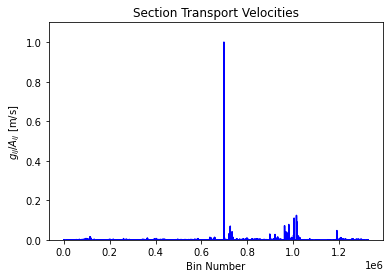

In [20]:
plt.plot(((g_ij/(range_yrs*yr2sec)*volnorming)/connected_Asection).flatten(), 'b')
plt.hlines(1, 0,1600, 'k')
plt.ylim(0,1.1)
plt.ylabel('$g_{ij}/A_{ij}$ [m/s]')
plt.xlabel('Bin Number')
plt.title('Section Transport Velocities')


In [21]:
# if Opt_twice:
#     '''constraint = [G@Q = V2*C2 - G@C2]
#         cost = cp.sum_squares( Q * volume/area )

#         where C1 is the initial and C2 is the final tracer concentrations.'''
#     result = MTM.optimise(tracers, volumes, constraints, weights)

#     g_ij = result['g_ij'] ## An [N x N] matrix of transports between WMs
#     Mixing = result['Mixing'] ## An [M x N] matrix of dtracer mixing for each WM
#     Adjustment = result['Adjustment'] ## An [M x N] matrix of dtracer adjustment for each WM

In [22]:
## Break down the Mixing and Adjustment matrices into their constituent tracers
dT_mixing = Mixing[1,:]
dS_mixing = Mixing[0,:]
dS_adj = Adjustment[0,:]
dT_adj = Adjustment[1,:]

----------
## E) Save Output 

In [23]:
da_dT_mixing = xr.DataArray(data = dT_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Mixing", units="\Delta K", variable_id="EN4 Tmix"))
da_dS_mixing = xr.DataArray(data = dS_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Mixing", units="\Delta g/kg", variable_id="EN4 Smix"))
da_dT_adjustment = xr.DataArray(data = dT_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Adjustment", units="\Delta K", variable_id="EN4 Tadj"))
da_dS_adjustment = xr.DataArray(data = dS_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Adjustment", units="\Delta g/kg", variable_id="EN4 Sadj"))
da_gij = xr.DataArray(data = g_ij*volnorming, dims = ["WM_initial", "WM_final"],
                           coords=dict(WM_initial = np.arange(0,N), WM_final = np.arange(0,N)),
                        attrs=dict(description="Volume transport", units="m^3", variable_id="EN4 Gij"))

## Create xarray DataSet that will hold all these DataArrays
ds_BSP = xr.Dataset()
ds_BSP['dT_mixing'] = da_dT_mixing
ds_BSP['dS_mixing'] = da_dS_mixing
ds_BSP['dT_adjustment'] = da_dT_adjustment
ds_BSP['dS_adjustment'] = da_dS_adjustment
ds_BSP['gij'] = da_gij

if SF:
   ds_BSP.to_netcdf('Optimisation_results/Optimal_result_EN4_SF_79_06.nc', mode='w')
else:
   ds_BSP.to_netcdf('Optimisation_results/Optimal_result_EN4_freerun.nc', mode='w')